In [3]:
import os
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np

import _3dpu_mehdi as mehdi
from _3dpu import *

In [2]:
!pip3 install ipympl
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [51]:
chemin = r"C:\Users\0\OneDrive\Documents\Montréal 4A\Les études\Chair AI-SCALE\ph.nii"
chemin2 = r"C:\Users\0\Downloads\TGVQSM-plus\TGVQSM-master-011045626121baa8bfdd6633929974c732ae35e3\test_data\epi3d_test_phase.nii"
chemin3 = r"C:\Users\0\Downloads\20170327_qsm2016_recon_challenge\20170327_qsm2016_recon_challenge\data\phs_wrap.nii"
phase_image = nb.load( chemin)
phase_image2 = nb.load(chemin2)
phase_image3 = nb.load(chemin3)
x_min,x_max = 20,140
y_min,y_max = 40,140
z_min,z_max = 10,60
t = 1
data = phase_image.get_data()[x_min:x_max,y_min:y_max,z_min:z_max,1]
data = phase_image2.get_data()
data3 = phase_image3.get_data()

C:\Users\0\AppData\Local\Temp\ipykernel_19044\2070477045.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = phase_image.get_data()[x_min:x_max,y_min:y_max,z_min:z_max,1]
C:\Users\0\AppData\Local\Temp\ipykernel_19044\2070477045.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = phase_image2.get_data()
C:\Users\0\AppData\Local\Temp\ipykernel_19044\2070477045.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more

In [52]:
data3.shape

(160, 160, 160)

In [12]:
Sat = mehdi.all_residuals(data)
with open('readme.txt', 'w') as f:
    Sat = mehdi.residual_loops(chemins,Sat)
    

new il reste89670
new il reste89638
new il reste89638
new il reste89632
new il reste89626
new il reste89626
new il reste89626
new il reste89626
new il reste89622
new il reste89622
new il reste89622
new il reste89622
new il reste89622
new il reste89622
new il reste89622
new il reste89622
new il reste89622
new il reste89614
new il reste89614
new il reste89614
new il reste89614
new il reste89614
new il reste89614
new il reste89614
new il reste89614
new il reste89614
new il reste89614
new il reste89614


KeyboardInterrupt: 

In [14]:
[len(ch[1]) for ch in chemins]

[33, 7, 7, 5, 9]

In [53]:
psi = data3
shape = psi.shape
# Store the list of all residuals.
res = []
for a in range(dim):
    res.append(residuals(psi, a))
marker1 = {}
unprocess_all(res, marker1)
# r = unprocessed_residual(marker)
# l = search_loop(SpinnedResidual(1, r), shape, marker, False)

259

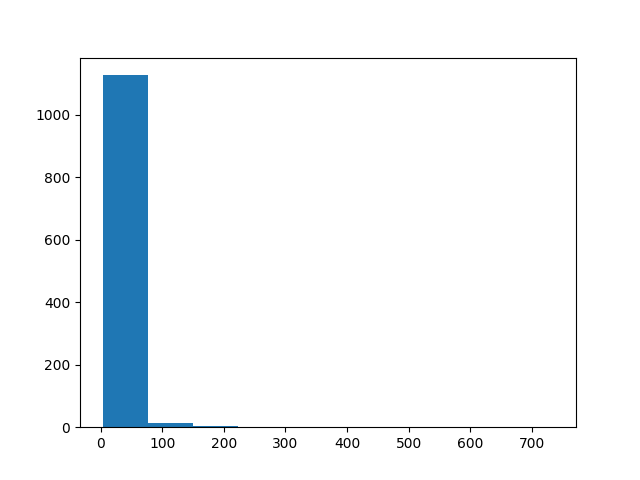

In [72]:
# lk = np.argmax([len(loop.loop) for loop in loops])
fig2 = plt.figure()
ax = fig2.add_subplot()
ax.hist([len(loop.loop) for loop in loops])
([len(loop.loop) for loop in loops]).index(211)

In [54]:
#code _3dpu.py
marker2 = {}
loops = []
l = residual_loops(loops,marker2,data)



this loop is dicarded
this loop is dicarded
this loop is dicarded
this loop is dicarded
[SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([0, 0, 7]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=-1, pos=array([0, 0, 8]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=-1, pos=array([1, 0, 8])))]
[SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([1, 0, 8]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([1, 0, 9]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([2, 0, 9]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([2, 0, 9]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([2, 1, 8]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([2, 2, 8]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([2, 2, 8]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([1, 3, 8]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([1, 4, 8]))), Spinned

KeyboardInterrupt: 

In [56]:
def f(x):
    return 3*x*x*(x-1) - 2*(x-1)*(x-1)*(x-1)
len(marker2.items())*100/f(160)

88.63655430862434

In [35]:
# marker1 = {}
unprocess_all(res,marker1)
s = SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=np.array([ 1, 79,  6])))
next_s = next_residual(s,marker1,True)
# b  =next_residual(next_s,marker1,True)
# next_s == next_residual(b,marker1,True)
search_loop(s,shape,marker1,True)
# s.is_boundary(shape)


Get neg
Get neg


FlaggedLoop(closed=False, loop=[SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 1, 79,  6]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 2, 78,  6]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 2, 79,  6])))])

In [7]:
from numpy import *
s = SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 2, 76, 47])))

unprocess_all(res,marker1)
next_s = next_residual(s,marker1)
print(next_s)
marker1[next_s.res] = 1
next_s2 = next_residual(s,marker1)
print(next_s2)
marker1[next_s2.res] = 1
# next_s3 = next_residual(s,marker1)
# print(next_s3)
# marker1[next_s3.res] = 1

SpinnedResidual(spin=-1, res=Residual(ax=2, ori=-1, pos=array([ 2, 75, 47])))
SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 2, 75, 48])))


In [25]:
retrouve = next_s
k1 = 0
for i,loop in enumerate(loops):
    if SpinnedResidual(1,retrouve.res) in loop.loop:
        k1 = i
# unprocess_all(res,marker1)
# pos1 = loops[13].loop[0]
# d = search_loop(pos1,shape,marker1,True)

# for pos in d.loop:

#     print(pos,marker1[pos.res])
loop_ret =  loops[k1].loop
print(next_s)
print(np.array(loop_ret))

NameError: name 'next_s' is not defined

In [9]:
retrouve = next_s2
k = 0
for i,loop in enumerate(loops):
    if SpinnedResidual(1,retrouve.res) in loop.loop:
        k = i
# unprocess_all(res,marker1)
# pos1 = loops[13].loop[0]
# d = search_loop(pos1,shape,marker1,True)

# for pos in d.loop:

#     print(pos,marker1[pos.res])
loop_ret2 =  loops[k].loop
print(next_s2)

print(np.array(loop_ret2))

AttributeError: 'NoneType' object has no attribute 'res'

In [29]:
from numpy import *
l1,l2 = [SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 7,  9, 49]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 7,  9, 48]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 6, 10, 48]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([ 7, 10, 48]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 7, 10, 48]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 7, 11, 47]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 7, 11, 47]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 6, 11, 47]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 6, 10, 47]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 6,  9, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 6,  8, 48]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 6,  8, 48]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 5,  9, 48]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 5,  9, 48]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 5,  9, 47]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 5,  8, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 4,  9, 47]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 4,  9, 47]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 4,  9, 46]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 4,  9, 45]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 4,  9, 44]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 4,  8, 45]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 4,  8, 46]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([ 5,  8, 46]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 5,  8, 46]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 5,  8, 45]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 5,  7, 45]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 5,  6, 45]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 4,  6, 45]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 3,  7, 45]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 3,  7, 46]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 3,  7, 46]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 2,  7, 47]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 2,  7, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 2,  6, 48]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 2,  6, 48]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 1,  6, 48]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 1,  6, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([ 2,  6, 46]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 2,  6, 46]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 2,  6, 45]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 1,  6, 45]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 1,  5, 45]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([ 2,  5, 44])))],[SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 2,  5, 44]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 2,  6, 44]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=-1, pos=array([ 2,  6, 44]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 2,  6, 43]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 3,  5, 43]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 3,  6, 43]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 3,  6, 44]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 3,  6, 44]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 4,  5, 44]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 4,  6, 44]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 4,  7, 44]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 4,  7, 45]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 4,  8, 45]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 4,  8, 46]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 5,  8, 46]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 5,  9, 46]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 5,  9, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 5,  9, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=-1, pos=array([ 5,  8, 47]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 4,  9, 47]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 4,  9, 48]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 4, 10, 48]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=-1, pos=array([ 4, 10, 48]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 3, 11, 48]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 3, 11, 49])))]


In [10]:
a = [1,2,4,2]
len(set(a))

3

In [65]:
marker2[( Residual(ax=0, ori=1, pos=np.array([53, 69,  0])))]

KeyError: Residual(ax=0, ori=1, pos=array([53, 69,  0]))

In [15]:
s = SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=np.array([ 5, 34, 48])))



next_s = next_residual(s,marker1,False)

# for loop in loops:
#     print()
#     print(loop)

# loops[-2] = loops[-2][1]


In [9]:
v = SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=np.array([53, 68,  0])))

# search_loop(v,shape,marker2,True)

potential_neighbors(v,True)

[SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([52, 68,  0]))),
 SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([52, 68,  0]))),
 SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([52, 69,  0]))),
 SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([52, 68,  0]))),
 SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([52, 68,  1])))]

In [100]:
pos = SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=np.array([ 5, 33, 49])))
unprocess_all(res,marker1)
search_loop(pos,shape,marker1)

FlaggedLoop(closed=False, loop=[SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 5, 33, 49])))])

In [21]:
l =np.array([len(loop.loop) for loop in loops])
max = np.argmax(l)


In [8]:
def next_residual(curr: SpinnedResidual, marker: ResidualMarker, reverse: bool = False, shuffle: bool = True):
    # List of potential neighbors.
    neighbors = potential_neighbors(curr, reverse)
    l = []
    # Shuffle the list of neighbors if asked to.
    if shuffle:
        random.shuffle(neighbors)

    # Look for the first neighbor that has not been
    # yet processed.
    for spinned_residual in neighbors:
        if spinned_residual.res in marker and marker[spinned_residual.res] == -1:
            l.append(spinned_residual)

    # Return None.
    return l

In [29]:
(marker2.values())

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [11]:
def potential_neighbors(self: SpinnedResidual) -> list[SpinnedResidual]:
    # List of potential neighbors.
    neighbors = []
    # Add the neighbor with the same axis as
    # the current residual.
    npos = deepcopy(self.res.pos)
    npos[self.res.ax] += self.spin
    neighbors.append(SpinnedResidual(self.spin, Residual(self.res.ax, self.res.ori, npos)))

    # Add the neighbors for other axes.
    for d in range(1, dim):
        na = (self.res.ax + d) % dim
        if self.spin == 1:
            for i, ns in zip([0, 1], [-1, 1]):
                npos = deepcopy(self.res.pos)
                npos[na] += i*self.spin
                neighbors.append(SpinnedResidual(ns, Residual(na, self.res.ori * ns, npos)))
        if self.spin == -1:
            for i, ns in zip([0, 1], [1, -1]):
                npos = deepcopy(self.res.pos)
                npos[na] += i
                npos[self.res.ax] -= 1
                neighbors.append(SpinnedResidual(self.spin*ns, Residual(na, self.res.ori * ns, npos)))
    return neighbors

(135.0, 156.0)

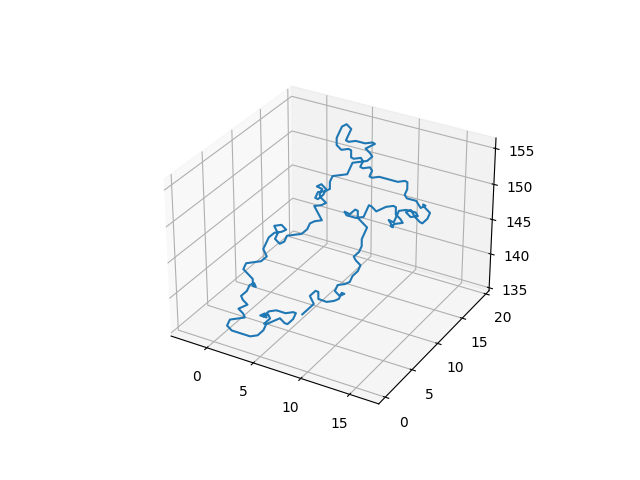

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
X = []
Y = []
Z = []
for loop in loops[259:259+1]:
    if True:
        lasso_positions = []
        for r in loop.loop:
            pos = [r.res.ax] + list(r.res.pos)
            if pos[0] == 2:
                new_pos = [pos[1]+0.5,pos[2] + 0.5,pos[3]]
            elif pos[0] == 1:
                new_pos = [pos[1]+0.5,pos[2],pos[3]+0.5]
            elif pos[0] == 0:
                new_pos = [pos[1],pos[2] + 0.5,pos[3]+0.5]
                
            lasso_positions.append(new_pos)
        xs = [pos[0] for pos in lasso_positions]
        ys = [pos[1] for pos in lasso_positions]
        zs = [pos[2] for pos in lasso_positions]
        ax.plot(xs,ys,zs)
        Z = Z + zs
        X = X + xs
        Y = Y + ys

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 + 0.5

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)



In [15]:
# len(set(loops[k1].loop))
len(loops[k1].loop)

30

In [50]:
def search_loop(start: SpinnedResidual, shape, marker: ResidualMarker, reverse: bool = False) -> FlaggedLoop:
    loop = []
    curr = start
    while True:
        loop.append(curr)
        marker[curr.res] = 0
        if curr.is_boundary(shape, reverse):
            # Boundary residual. FAUX !!
            return FlaggedLoop(False, loop)
        else:
            i = close_loop(curr, loop, reverse)
            print(i,curr,loop)
            if i != -1:
                # Unmark all residuals before i.
                mark_loop(loop[:i], marker, -1)

                # Mark all residuals after i as processed.
                mark_loop(loop[i:], marker, 1)

                loop = [curr] + loop[i:] 

                # Retreive only the loop.
                return FlaggedLoop(True, loop)
            else:
                # Get the next residual.
                neighbor = next_residual(curr, marker, reverse)
                if neighbor:
                    curr = neighbor
                    
                else:
                    # TODO: handle this.
                    raise ValueError()

In [18]:
[loop.closed for loop in loops]
loop = loops[0].loop
loop

[SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 0, 76,  1]))),
 SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 0, 77,  1]))),
 SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 1, 77,  1]))),
 SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 1, 78,  1]))),
 SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 1, 78,  2]))),
 SpinnedResidual(spin=-1, res=Residual(ax=0, ori=-1, pos=array([ 1, 78,  2]))),
 SpinnedResidual(spin=-1, res=Residual(ax=2, ori=-1, pos=array([ 0, 78,  2]))),
 SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 0, 78,  1])))]

In [51]:
unprocess_all(res,marker)
r = Residual(ax=0, ori=1, pos=np.array([ 0, 76,  1]))
d = search_loop(SpinnedResidual(1, r), shape, marker, False)

-1 SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 0, 76,  1]))) [SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 0, 76,  1])))]
-1 SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 0, 77,  1]))) [SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 0, 76,  1]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 0, 77,  1])))]
-1 SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 1, 77,  1]))) [SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 0, 76,  1]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 0, 77,  1]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 1, 77,  1])))]
-1 SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 1, 78,  1]))) [SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 0, 76,  1]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 0, 77,  1]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 1,

In [52]:
d

FlaggedLoop(closed=True, loop=[SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 0, 78,  1]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 1, 77,  1]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 1, 78,  1]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 1, 78,  2]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=-1, pos=array([ 1, 78,  2]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=-1, pos=array([ 0, 78,  2]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 0, 78,  1])))])